In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

#### Setup input pipeline

In [3]:
dataset, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)
dataset

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteRW1S0T/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteRW1S0T/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteRW1S0T/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


{'test': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 'train': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 'unsupervised': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>}

In [4]:
train_dataset, test_dataset = dataset['train'], dataset['test']

In [5]:
for text, label in train_dataset.take(1):
    print(f"{text.numpy()}")
    print(f"{label.numpy()}")

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
0


In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#### Create text encoder

In [7]:
VOCAB_SIZE = 10000

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)

encoder.adapt(train_dataset.map(lambda text, label: text))

In [8]:
vocab = np.array(encoder.get_vocabulary())
vocab[:10]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it'],
      dtype='<U17')

In [9]:
tokenised_example = encoder("This is a good movie.")
tokenised_example

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([11,  7,  4, 50, 18])>

#### Create the model

In [10]:
def build_model():
    model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(input_dim=encoder.vocabulary_size(), output_dim=64, mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    return model

In [11]:
model = build_model()

for layer in model.layers:
    print(f"{layer.supports_masking}")

False
True
True
True
True


In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.00054491]


In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.0005449]


In [14]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(1e-4),
    metrics = ["accuracy"]
)

#### Train the model

In [15]:
history = model.fit(
    train_dataset,
    validation_data = test_dataset,
    validation_steps=30,
    epochs=10
)

Epoch 1/10
391/391 [==============================] - 140s 332ms/step - loss: 0.5999 - accuracy: 0.6132 - val_loss: 0.4466 - val_accuracy: 0.8062
Epoch 2/10
391/391 [==============================] - 127s 323ms/step - loss: 0.3606 - accuracy: 0.8533 - val_loss: 0.3364 - val_accuracy: 0.8687
Epoch 3/10
391/391 [==============================] - 125s 319ms/step - loss: 0.2512 - accuracy: 0.9023 - val_loss: 0.3135 - val_accuracy: 0.8755
Epoch 4/10
391/391 [==============================] - 126s 320ms/step - loss: 0.2020 - accuracy: 0.9251 - val_loss: 0.3057 - val_accuracy: 0.8833
Epoch 5/10
391/391 [==============================] - 126s 321ms/step - loss: 0.1646 - accuracy: 0.9422 - val_loss: 0.3386 - val_accuracy: 0.8760
Epoch 6/10
391/391 [==============================] - 125s 319ms/step - loss: 0.1370 - accuracy: 0.9540 - val_loss: 0.3465 - val_accuracy: 0.8698
Epoch 7/10
391/391 [==============================] - 126s 319ms/step - loss: 0.1178 - accuracy: 0.9608 - val_loss: 0.3462 -

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 48s 123ms/step - loss: 0.4152 - accuracy: 0.8613
Test Loss: 0.41516461968421936
Test Accuracy: 0.8612800240516663


(0.0, 0.6259699985384941)

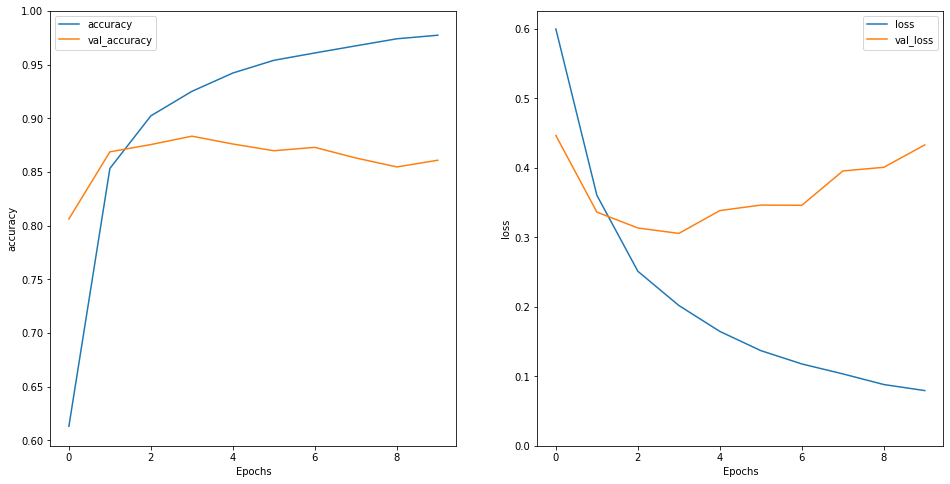

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [18]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

In [19]:
predictions

array([[1.9329304]], dtype=float32)

#### Reference

1. [Text classification with an RNN](https://www.tensorflow.org/text/tutorials/text_classification_rnn)